# 7

In [29]:
import os
import time
import torch
import kagglehub
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms

## Implement a CNN for MNIST in Pytorch

### Load and Preprocess the MNIST Dataset

#### Data Transformation

In [80]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalizing to mean 0.5 and std 0.5 for MNIST
])

#### Load Data

In [81]:
train_data = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_data = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

#### Train, Validation & Test

In [82]:
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_data, val_data = random_split(train_data, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=64, shuffle=True, drop_last=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

### CNN Model

In [83]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=3)  # Conv layer with 8 filters
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=3)  # Conv layer with 8 filters
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 10 * 10, 128)  # Fully connected layer with 64 units
        self.fc2 = nn.Linear(128, 10)         # Output layer with 10 units
        
    def _forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # First conv layer + ReLU + Pool
        x = self.pool(torch.relu(self.conv2(x)))  # Second conv layer + ReLU + Pool             # Output layer
        return x
    
    def __getforwardsize__(self):
        x = torch.randn(1, 1, 28, 28) 
        return self._forward(x).shape
    
    def forward(self, x):
        self._forward(x)
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 10 * 10)  # Flatten for fully connected layers
        x = torch.relu(self.fc1(x))  # First fully connected layer + ReLU
        x = self.fc2(x)
        return x  # No softmax; CrossEntropyLoss applies softmax

# Instantiate model, define loss function and optimizer
model = CNN()

outputsize = model.__getforwardsize__()
output_size = np.prod(outputsize)
print("Output size:", (output_size))

Output size: 6400


Define Loss Function and Optimizer

In [84]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Train and Test the Model

#### Training Function

In [85]:
def train_model(num_epochs):
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    start_time = time.time()
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training loop
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)

        # Validation loop
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        val_loss /= len(val_loader)
        val_acc = 100 * correct_val / total_val
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    total_train_time = time.time() - start_time
    return train_loss_history, val_loss_history, train_acc_history, val_acc_history, total_train_time

#### Train and Validate the model

In [86]:
num_epochs = 5
train_loss_history, val_loss_history, train_acc_history, val_acc_history, total_train_time = train_model(num_epochs)

Epoch 1/5, Train Loss: 0.1942, Train Acc: 94.09%, Val Loss: 0.0618, Val Acc: 97.97%
Epoch 2/5, Train Loss: 0.0548, Train Acc: 98.29%, Val Loss: 0.0484, Val Acc: 98.54%
Epoch 3/5, Train Loss: 0.0365, Train Acc: 98.86%, Val Loss: 0.0359, Val Acc: 98.87%
Epoch 4/5, Train Loss: 0.0277, Train Acc: 99.18%, Val Loss: 0.0359, Val Acc: 98.95%
Epoch 5/5, Train Loss: 0.0203, Train Acc: 99.33%, Val Loss: 0.0435, Val Acc: 98.73%


#### Plot Training and Validation loss

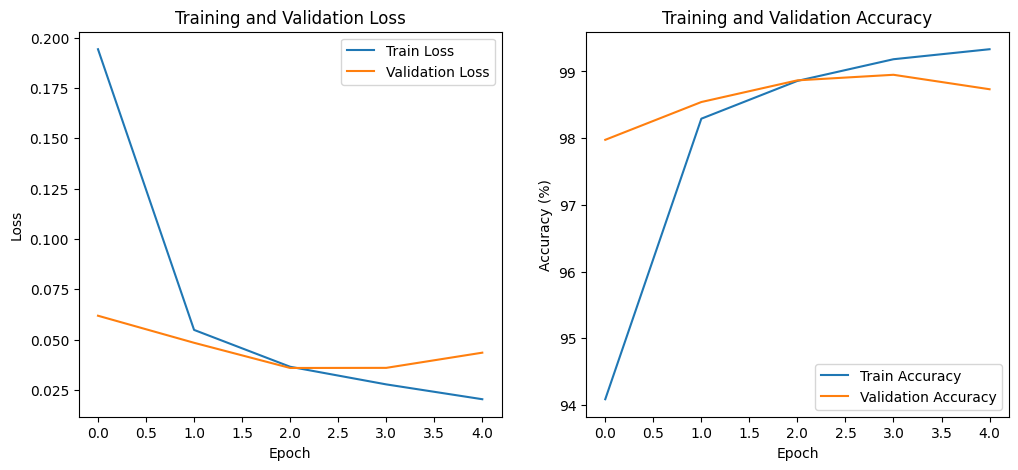

In [87]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

#### Save the model

In [88]:
torch.save(model.state_dict(), 'mnist_cnn_model.pth')

#### Testing Function

In [89]:
def test_model():
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the model on test images: {100 * correct / total:.2f}%')

# Load and test the model
model.load_state_dict(torch.load('mnist_cnn_model.pth'))
test_model()

C:\Users\NaderZadeh\AppData\Local\Temp\ipykernel_11084\836420763.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('mnist_cnn_model.pth')

Accuracy of the model on test images: 98.60%


## Q1

### Load CIFAR-10 Dataset

#### Download dataset from Kaggle

In [10]:
path = kagglehub.dataset_download("pankrzysiu/cifar10-python")
print("Path to dataset files:", path)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images
])

Path to dataset files: C:\Users\NaderZadeh\.cache\kagglehub\datasets\pankrzysiu\cifar10-python\versions\1


#### Define train and test Data

In [40]:
train_dataset = datasets.CIFAR10(root=path, train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root=path, train=False, transform=transform, download=True)

Files already downloaded and verified
Files already downloaded and verified


#### Create data loaders for train and test

In [41]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

### CNN model

In [34]:
class Net(nn.Module):
    def __init__(self, use_batch_norm=False):
        super(Net, self).__init__()
        self.use_batch_norm = use_batch_norm
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        
        if self.use_batch_norm:
            self.bn = nn.BatchNorm1d(128)
        
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        if self.use_batch_norm:
            x = self.bn(x)
        x = self.fc2(x)
        return x

### Training and evaluation function

In [35]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [36]:
def train_model(model, optimizer, num_epochs=20):
    criterion = nn.CrossEntropyLoss()
    model.to(device)
    
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = 100 * correct / total
        train_loss_list.append(epoch_loss)
        train_acc_list.append(epoch_acc)
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_epoch_loss = val_running_loss / len(test_loader.dataset)
        val_epoch_acc = 100 * val_correct / val_total
        val_loss_list.append(val_epoch_loss)
        val_acc_list.append(val_epoch_acc)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, '
              f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.2f}%')
    
    return {
        'train_loss': train_loss_list,
        'train_acc': train_acc_list,
        'val_loss': val_loss_list,
        'val_acc': val_acc_list
    }

### Train the model

#### Train the model with batch normalization

In [37]:
print("\nTraining model WITH batch normalization:")
model_with_bn = Net(use_batch_norm=True)
optimizer_with_bn = optim.Adam(model_with_bn.parameters())
history_with_bn = train_model(model_with_bn, optimizer_with_bn)


Training model WITH batch normalization:
Epoch [1/20], Train Loss: 1.1601, Train Acc: 59.27%, Val Loss: 0.9743, Val Acc: 65.84%
Epoch [2/20], Train Loss: 0.8510, Train Acc: 70.33%, Val Loss: 0.8628, Val Acc: 69.81%
Epoch [3/20], Train Loss: 0.7165, Train Acc: 75.07%, Val Loss: 0.8260, Val Acc: 71.28%
Epoch [4/20], Train Loss: 0.6206, Train Acc: 78.27%, Val Loss: 0.8247, Val Acc: 72.51%
Epoch [5/20], Train Loss: 0.5314, Train Acc: 81.39%, Val Loss: 0.8635, Val Acc: 71.19%
Epoch [6/20], Train Loss: 0.4509, Train Acc: 84.27%, Val Loss: 0.8664, Val Acc: 73.09%
Epoch [7/20], Train Loss: 0.3718, Train Acc: 87.05%, Val Loss: 0.9359, Val Acc: 71.78%
Epoch [8/20], Train Loss: 0.3046, Train Acc: 89.41%, Val Loss: 1.0124, Val Acc: 71.31%
Epoch [9/20], Train Loss: 0.2488, Train Acc: 91.47%, Val Loss: 1.0860, Val Acc: 71.31%
Epoch [10/20], Train Loss: 0.2040, Train Acc: 93.03%, Val Loss: 1.0820, Val Acc: 72.34%
Epoch [11/20], Train Loss: 0.1640, Train Acc: 94.41%, Val Loss: 1.2524, Val Acc: 70.37%

#### Train the model without batch normalization

In [38]:
print("\nTraining model WITHOUT batch normalization:")
model_without_bn = Net(use_batch_norm=False)
optimizer_without_bn = optim.Adam(model_without_bn.parameters())
history_without_bn = train_model(model_without_bn, optimizer_without_bn)


Training model WITHOUT batch normalization:
Epoch [1/20], Train Loss: 1.3598, Train Acc: 51.47%, Val Loss: 1.1095, Val Acc: 60.54%
Epoch [2/20], Train Loss: 0.9844, Train Acc: 65.21%, Val Loss: 0.9694, Val Acc: 66.34%
Epoch [3/20], Train Loss: 0.8151, Train Acc: 71.45%, Val Loss: 0.9075, Val Acc: 68.03%
Epoch [4/20], Train Loss: 0.7119, Train Acc: 75.02%, Val Loss: 0.8396, Val Acc: 70.49%
Epoch [5/20], Train Loss: 0.6158, Train Acc: 78.42%, Val Loss: 0.8636, Val Acc: 70.29%
Epoch [6/20], Train Loss: 0.5225, Train Acc: 81.72%, Val Loss: 0.8486, Val Acc: 72.14%
Epoch [7/20], Train Loss: 0.4458, Train Acc: 84.55%, Val Loss: 0.9286, Val Acc: 69.90%
Epoch [8/20], Train Loss: 0.3712, Train Acc: 86.99%, Val Loss: 0.9467, Val Acc: 71.78%
Epoch [9/20], Train Loss: 0.3010, Train Acc: 89.45%, Val Loss: 1.0025, Val Acc: 71.93%
Epoch [10/20], Train Loss: 0.2392, Train Acc: 91.79%, Val Loss: 1.1303, Val Acc: 71.46%
Epoch [11/20], Train Loss: 0.1988, Train Acc: 93.03%, Val Loss: 1.2097, Val Acc: 71.

### Plot the results

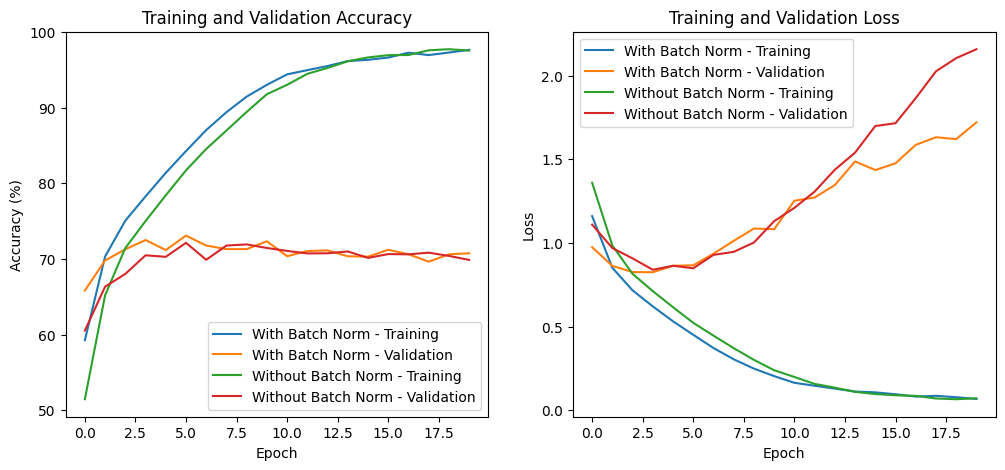

In [39]:
plt.figure(figsize=(12, 5))

# Accuracy comparison
plt.subplot(1, 2, 1)
plt.plot(history_with_bn['train_acc'], label='With Batch Norm - Training')
plt.plot(history_with_bn['val_acc'], label='With Batch Norm - Validation')
plt.plot(history_without_bn['train_acc'], label='Without Batch Norm - Training')
plt.plot(history_without_bn['val_acc'], label='Without Batch Norm - Validation')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Loss comparison
plt.subplot(1, 2, 2)
plt.plot(history_with_bn['train_loss'], label='With Batch Norm - Training')
plt.plot(history_with_bn['val_loss'], label='With Batch Norm - Validation')
plt.plot(history_without_bn['train_loss'], label='Without Batch Norm - Training')
plt.plot(history_without_bn['val_loss'], label='Without Batch Norm - Validation')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Q2

**the types of neural networks and layers that can't be implemented using nn.Sequential:**

>    1- Networks with Multiple Inputs or Outputs: nn.Sequential doesn’t support networks where multiple inputs or outputs are required, such as in cases where layers receive multiple tensors or output multiple tensors.

>    2- Layers with Conditional Execution: If the network requires conditional execution, where some layers are only executed based on a condition (like using an if statement), nn.Sequential can't accommodate this.

>    3- Layers with Conditional Execution: If the network requires conditional execution, where some layers are only executed based on a condition (like using an if statement), nn.Sequential can't accommodate this.

>    4- Layers with Conditional Execution: If the network requires conditional execution, where some layers are only executed based on a condition (like using an if statement), nn.Sequential can't accommodate this.

>    5- Networks with Custom Layer Behavior: If a network requires custom behavior (e.g., custom layer interactions or state-dependent computations), nn.Sequential is insufficient.


*solution*:
By creating a custom nn.Module, we can define the forward method ourselves, which provides the flexibility required for more complex architectures.

*for example*

```python
class CustomNetwork(nn.Module):
    def __init__(self):
        super(CustomNetwork, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(64 * 28 * 28, 10)
        self.skip_connection = nn.Conv2d(1, 64, kernel_size=1, stride=1)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        
        skip = self.skip_connection(x)
        x2 += skip
        
        x2 = x2.view(x2.size(0), -1)
        output = self.fc(x2)
        return output
```